For this exercise, you may need to install the `networkx` and `skimage` modules in your local environment.

In [68]:
import skimage
import numpy as np
%matplotlib notebook
from matplotlib import pyplot as plt
from networkx import grid_graph
import networkx as nx 
%pylab inline
%load_ext autoreload
%autoreload 2

from cvf20.unionfind import UnionFind as UF

Populating the interactive namespace from numpy and matplotlib
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# 1 Maze Generation with Kruskal's algorithm

Finish the implementation in the code block below:

In [40]:
# Dimension of the generated maze:
field_shape = (16, 16)

# make a union find datastructure for all nodes
uf = UF()
for x in range(field_shape[0]):
    for y in range(field_shape[1]):
        uf.add((x,y))

# Create a gridgraph:
# - Nodes are given by a tuple of 2D coordinates representing the position of the pixel in the image, e.g. (2,4)
# - Edges are given by a tuple of two nodes, e.g. ((0,1), (0,2))
G = grid_graph(dim=list(field_shape)) # G is an instance of networkx.classes.graph.Graph 

# Create random weights
edge_weights = np.array([[e, random.rand()] for e in G.edges()]) # shape (nb_edges, 2)
for e, weight in edge_weights:
    G[e[0]][e[1]]['weight'] = weight
nodes = [n for n in G.nodes()]

    
# We will add edges to the list 
MST = []
# that make up the minimal spanning tree

### ----------------------------------------
### Your Kruskal implementation goes here
### ----------------------------------------            
sorted_edges = sorted(edge_weights, key=lambda edge:edge[1])
for edge in sorted_edges:
        u, v = edge[0]
        # print('u=',u,'v=',v)
        # if u, v already connected, abort this edge
        if uf.connected(u, v):
            continue
        # if not, connect them and add this edge to the MST
        uf.union(u, v)
        MST.append(edge[0])
# MST

And then test it by plotting the created maze:

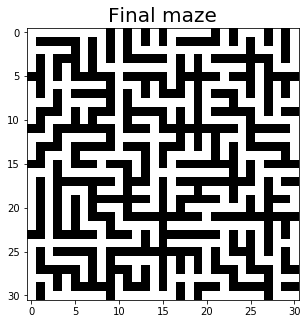

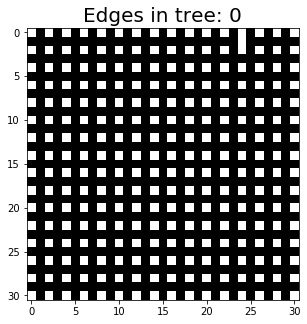

In [38]:
from matplotlib import animation
from IPython.display import HTML

def visualize_MSTs(MST):
    
    maze = np.zeros([len(MST)+20]+[2*f for f in field_shape])
    maze[:, :-1:2, :-1:2] = 1
    
    for i,(n1, n2) in enumerate(MST):
        n1 = np.asarray(n1)
        n2 = np.asarray(n2)
        w1 = n1 + 0.5*(n2-n1)
        maze[i:, int(2*w1[0]), int(2*w1[1])] = 1
    return maze

maze = visualize_MSTs(MST)

# Visualize final maze:
fig, ax = plt.subplots(figsize=(5, 5))
ax.imshow(maze[-1, :-1, :-1], cmap='gray')
ax.set_title("Final maze", fontsize=20)
# ax.set_axis_off()
plt.show()

# Animate Maze creation:
fig, ax = plt.subplots(figsize=(5, 5))

def update(i):
    ax.imshow(maze[i, :-1, :-1], cmap='gray')
    ax.set_title("Edges in tree: {}".format(i), fontsize=20)
    return (ax, )
    
anim = animation.FuncAnimation(fig, update, frames=np.arange(0, len(MST), 4), interval=200)

# Display the animation in the notebook:
HTML(anim.to_html5_video())

In [41]:
# Save animation to file:
Writer = animation.writers['ffmpeg']
writer = Writer(fps=15, bitrate=1800)

anim.save('im.mp4', writer=writer)

### 1b) Modification for an unsolvable maze:
Insert your code below

480
449


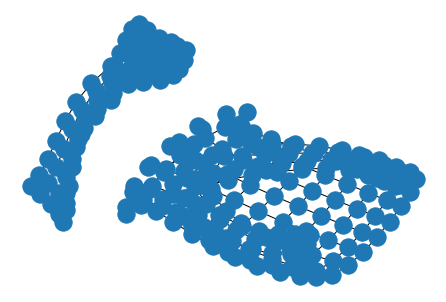

In [98]:
### Your code goes here
UG = grid_graph(dim=list(field_shape))
print(len(UG.edges))
for e in UG.edges:
    if e[0][0]==10: 
        UG.remove_edge(*e)
print(len(UG.edges))
pos = nx.spring_layout(UG)
nx.draw(UG,pos)

# 2. Cell Segmentation with the Watershed Algorithm

### Load and plot input data

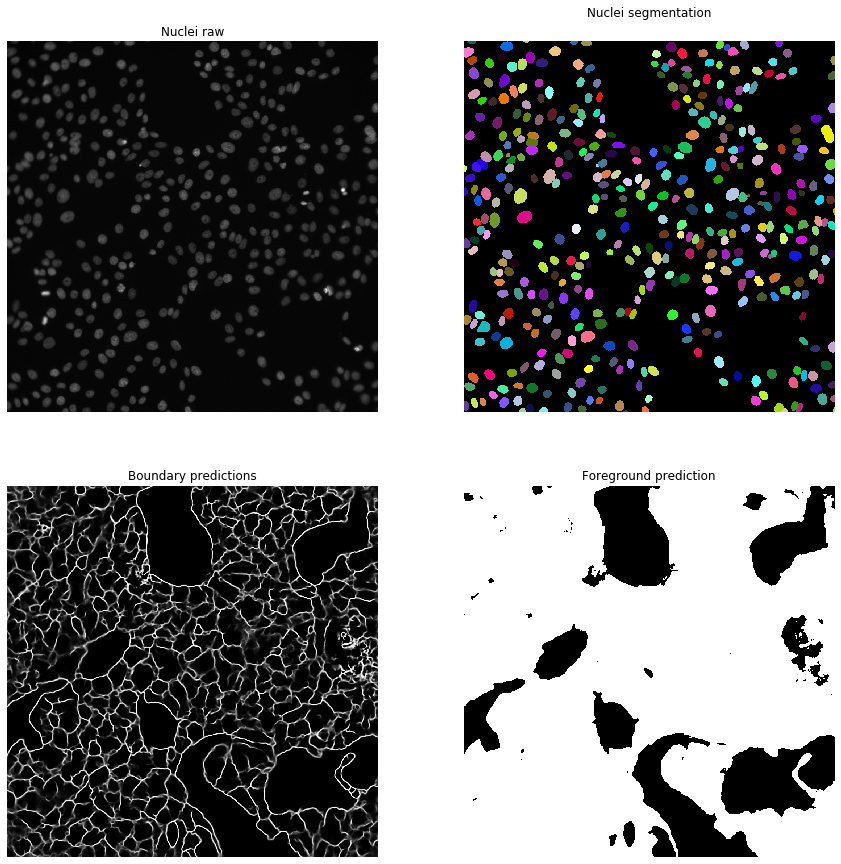

In [99]:
from cvf20.utils import readHDF5, plot_segm

filename = "./data/serum_data.h5"

boundaries = readHDF5(filename, "boundaries")
serum_IgA = readHDF5(filename, "serum_IgA")
foreground = readHDF5(filename, "foreground_prediction")
nuclei_segmentation = readHDF5(filename, "nuclei_segmentation")
nuclei_raw = readHDF5(filename, "nuclei_raw")


cmap="gray"

f, ax = plt.subplots(ncols=2, nrows=2, figsize=(15,15))
ax[0,0].imshow(nuclei_raw, cmap=cmap) 
ax[0,0].axis('off')
ax[0,0].set_title("Nuclei raw")
plot_segm(ax[0,1], nuclei_segmentation)
ax[0,1].axis('off')
ax[0,1].set_title("Nuclei segmentation")
ax[1,0].imshow(boundaries, cmap=cmap)
ax[1,0].axis('off')
ax[1,0].set_title("Boundary predictions")
ax[1,1].imshow(foreground, cmap=cmap) 
ax[1,1].axis('off')
ax[1,1].set_title("Foreground prediction")

plt.show()

### Your code goes here 

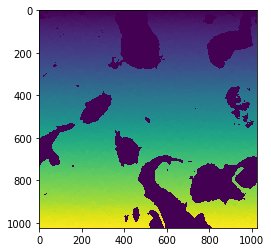

In [127]:
from skimage.segmentation import watershed
#from scipy import ndimage as ndi
#from skimage.morphology import local_minima

### Compute watershed segmentation here (from local minima)

#distance = ndi.distance_transform_edt(boundaries)
#local_min = local_minima(boundaries)
#markers = ndi.label(local_min)[0]

#WS_segm = watershed(-distance, markers, mask=boundaries)

#print("distance=",distance,'\n\n local_min=',local_min, '\n\n markers=', markers)
#plt.imshow(WS_segm)



WS_segm = watershed(image=boundaries, markers=None, connectivity=1, offset=None, mask=foreground, compactness=0, watershed_line=False)
plt.imshow(WS_segm)

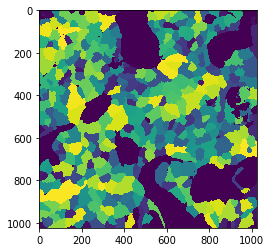

In [125]:
from skimage.segmentation import watershed

### Compute seeded watershed segmentation here

seeded_WS_segm = watershed(image=boundaries, markers=nuclei_segmentation, connectivity=1, offset=None, mask=foreground, compactness=0, watershed_line=False)
plt.imshow(seeded_WS_segm)

### Plot your results

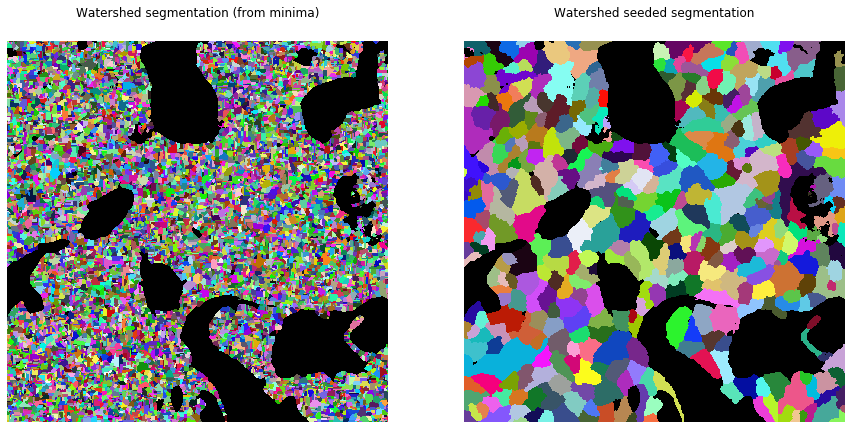

In [128]:
if seeded_WS_segm is not None and WS_segm is not None:
    f, ax = plt.subplots(ncols=2, nrows=1, figsize=(15,15))
    plot_segm(ax[0], WS_segm)
    ax[0].axis('off')
    ax[0].set_title("Watershed segmentation (from minima)")
    plot_segm(ax[1], seeded_WS_segm)
    ax[1].axis('off')
    ax[1].set_title("Watershed seeded segmentation")
    plt.show()

### 2b) COMMENTS: 
When the local minima is used, the watershed segmentation becomes too granular and results in over-segmentation. 
On the other hand, when the nuclei segmentation is used as seeds, the segmentation is more meaningful and relevant.

# 3. Mutex Watershed

Once you have finished implementing the Mutex Watershed algorithm in `cvf20/mws_python.py`, run the next block to test your implementation.

In [ ]:
from cvf20.mws_python import MWS
from cvf20.arand import adapted_rand
import time
import h5py
import networkx as nx

# Load graph weights from file:
# - each edge is given by a tuple of two node IDs (u, v)
with h5py.File("./data/cremi_data.h5", "r") as h:
    raw = h["raw"][:]
    gt = h["gt"][:]
    sp = h["sp"][:]
    edge_costs = -h["edge_costs"][:]
    edges = h["edges"][:]
    raw = h["raw"][:]

# Build graph in Networkx:
g = nx.Graph()
for i, (u, v) in enumerate(edges):
    g.add_edge(u, v, w=edge_costs[i])

print("Running mutex_watershed...")
mws_seg = np.asarray(MWS(g, edges, edge_costs))


# Compute scores:
ar, prec, recall = adapted_rand(mws_seg[sp], gt)
print("Adapted rand score: {}; Precision: {}; Recall: {}".format(ar, prec, recall))


# Plot the results:
f, ax = plt.subplots(ncols=2, nrows=1, figsize=(15,15))
plot_segm(ax[0],mws_seg[sp], with_background_label=False, alpha_labels=0.4, background_image=raw)
ax[0].set_title("Mutex Watershed segmentation")
plot_segm(ax[1],gt, with_background_label=False, alpha_labels=0.4, background_image=raw)
ax[1].set_title("Ground truth segmentation")
plt.show()